## 3D Linear Regression Distortion Correction

James Lamb

### Attempts

1) 3D distortion field in the form of adding a `model_k` to extend the regression analysis to the third dimension. This did **not** work. I was unable to get the three models into a transformation object that could be read by *skimage*.

> ```python
> # Create the models
> params = []
> for i in range(3):
>     model = Pipeline([("poly", PolynomialFeatures(degree=deg, include_bias=True)),
>                             ("linear", LinearRegression(fit_intercept=False))])
>     model.fit(src, dst[:,i])
>     params.append(model.named_steps["linear"].coef_)
> # Create the transformation object
> transform = tf._geometric.PolynomialTransform(params)
> # Align the dataset
> aligned_dataset = tf.warp(dataset, transform, cval=0, order=0, preserve_range=True,)
> ```


_____

2) Calculate a transformation matrix in 3D that connects the input coordinate locations to the output coordinate locations. I was able to get this to play nicely with *skimage*. However, the transformation matrix did not accurately capture the distortion field and the results were lackluster. The corrected EBSD images were warped, but the warping did not match the BSE images. This lead me to believe that I need a more powerful transformation object that accounts for non-affine distortions.

> ```python
> # Create transformation matrix
> t_matrix = tf._geometric._umeyama(src, dst, estimate_scale=False)
> # Create original coordinate locations of the entire volume
> xr = np.arange(data.shape[2])
> yr = np.arange(data.shape[1])
> zr = np.arange(data.shape[0])
> zz, yy, xx = np.meshgrid(zr, yr, xr, indexing="ij")
> points = np.hstack((zz.reshape(-1, 1), yy.reshape(-1, 1), xx.reshape(-1, 1)))
> # Transform to new locations and create transformation object
> new_points = np.around(t_matrix[:3, :3].dot(points.T).T, 0).astype(int)
> z = new_points[:, 0].reshape(zz.shape)
> y = new_points[:, 1].reshape(yy.shape)
> x = new_points[:, 2].reshape(xx.shape)
> transform = np.array([z, y, x])
> # Align the dataset
> aligned_dataset = tf.warp(dataset, transform, cval=0, order=0, preserve_range=True,)
> ```

___

3) Create a set of 2D distortion fields and apply to the dataset. This method seems like a hack... but the thought is to use linear regression to create a 2D distortion correction field on a few slices in the dataset. From there, interpolate the polynomial coefficients so that we have a unique transformation object for each slice. The alternative here is to interpolate the control points themselves instead of the polynomial coefficients. This method is implemented in the code below with pictures to aid visualization.

> ```python
> # Get the parameters for each slice with control points
> slice_numbers = [...] # shape (N,) where N is the number of slices with control points
> src = [...] # shape (N, M) where M is the number of control points
> dst = [...] # shape (N, M) where M is the number of control points
> params = []
> for i in range(len(slice_numbers)):
>     slice_params = []
>     for i in range(2):
>         model = Pipeline([("poly", PolynomialFeatures(degree=deg, include_bias=True)),
>                           ("linear", LinearRegression(fit_intercept=False))])
>         model.fit(src[i], dst[i,:,i])
>         slice_params.append(model.named_steps["linear"].coef_)
>     params.append(slice_params)
> # Create function to interpolate coefficients
> f = interpolate.interp1d(slice_numbers, params, axis=0)
> # Create transform object for each slice and warp
> aligned_dataset = np.zeros(dataset.shape, dtype=dataset.dtype)
> for i in range(dataset.shape[0]):
>     params = f(0)
>     transform = tf._geometric.PolynomialTransform(params)
>     aligned_slice = tf.warp(dataset[i], transform, cval=0, order=0, preserve_range=True).astype(dataset.dtype)
>     aligned_dataset[i] = aligned_slice
> ```



In [19]:
import os
import sys
sys.path.insert(0, "D:/Research/scripts/paraview_analysis")

import h5py
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from skimage import transform, io
import matplotlib.pyplot as plt
from scipy import interpolate

# parameters of the polynomial function
deg = 3

def create_model(deg):
    model = Pipeline(
        [
            ("poly", PolynomialFeatures(degree=deg, include_bias=True)),
            ("linear", LinearRegression(fit_intercept=False)),
        ]
    )
    return model

def warp_image(im, tform):
    aligned = transform.warp(
        im,
        tform,
        cval=0,  # new pixels are black pixel
        order=0,  # k-neighbour
        preserve_range=True,
    )
    return aligned.astype(im.dtype)

def get_ctr_pts(path):
    return np.loadtxt(open(path, "rb"), delimiter=" ").astype(int)
    

In [27]:
folder = "D:/Research/scripts/Alignment/CoNi16_3D/"
path = "D:/Research/CoNi_16/Data/3D/CoNi16.dream3d"
h5 = h5py.File(path, "r")
dataset = h5["DataContainers/ImageDataContainer/CellData/CI"][:, :, :, 0]
print(dataset.shape)

# Read control points from files
coord_ebsd_paths = sorted([x for x in os.listdir(folder) if "ebsd" in x])
coord_bse_paths = sorted([x for x in os.listdir(folder) if "bse" in x])

dst = []
src = []
slice_numbers = []
for i in range(len(coord_bse_paths)):
    path_bse = coord_bse_paths[i]
    path_ebsd = coord_ebsd_paths[i]
    slice_num = int(coord_bse_paths[i].split("_")[-2])
    src = get_ctr_pts(os.path.join(folder, path_bse))
    dst = get_ctr_pts(os.path.join(folder, path_ebsd))
    slice_numbers.append(slice_num)

(460, 421, 634)


In [21]:

params = []
for i in range(len(slice_numbers)):
    slice_params = []
    for i in range(2):
        model = Pipeline([("poly", PolynomialFeatures(degree=deg, include_bias=True)),
                          ("linear", LinearRegression(fit_intercept=False))])
        model.fit(src, dst[:,i])
        slice_params.append(model.named_steps["linear"].coef_)
    params.append(slice_params)
# Create function to interpolate coefficients
f = interpolate.interp1d(slice_numbers, params, axis=0)
# Create transform object for each slice and warp
aligned_dataset = np.zeros(dataset.shape, dtype=dataset.dtype)
for i in range(dataset.shape[0]):
    params = f(0)
    tform = transform._geometric.PolynomialTransform(params)
    aligned_slice = transform.warp(dataset[i], tform, cval=0, order=0, preserve_range=True).astype(dataset.dtype)
    aligned_dataset[i] = aligned_slice

In [29]:
# Get the BSE images
bse_folder = "D:/Research/CoNi_16/Data/3D/BSE/small/"
paths = sorted([path for path in os.listdir(bse_folder) if ".tif" in path], key=lambda x: int(x.replace(".tiff","")))
bse_imgs = np.array([io.imread(bse_folder+path, as_gray=True) for path in paths])

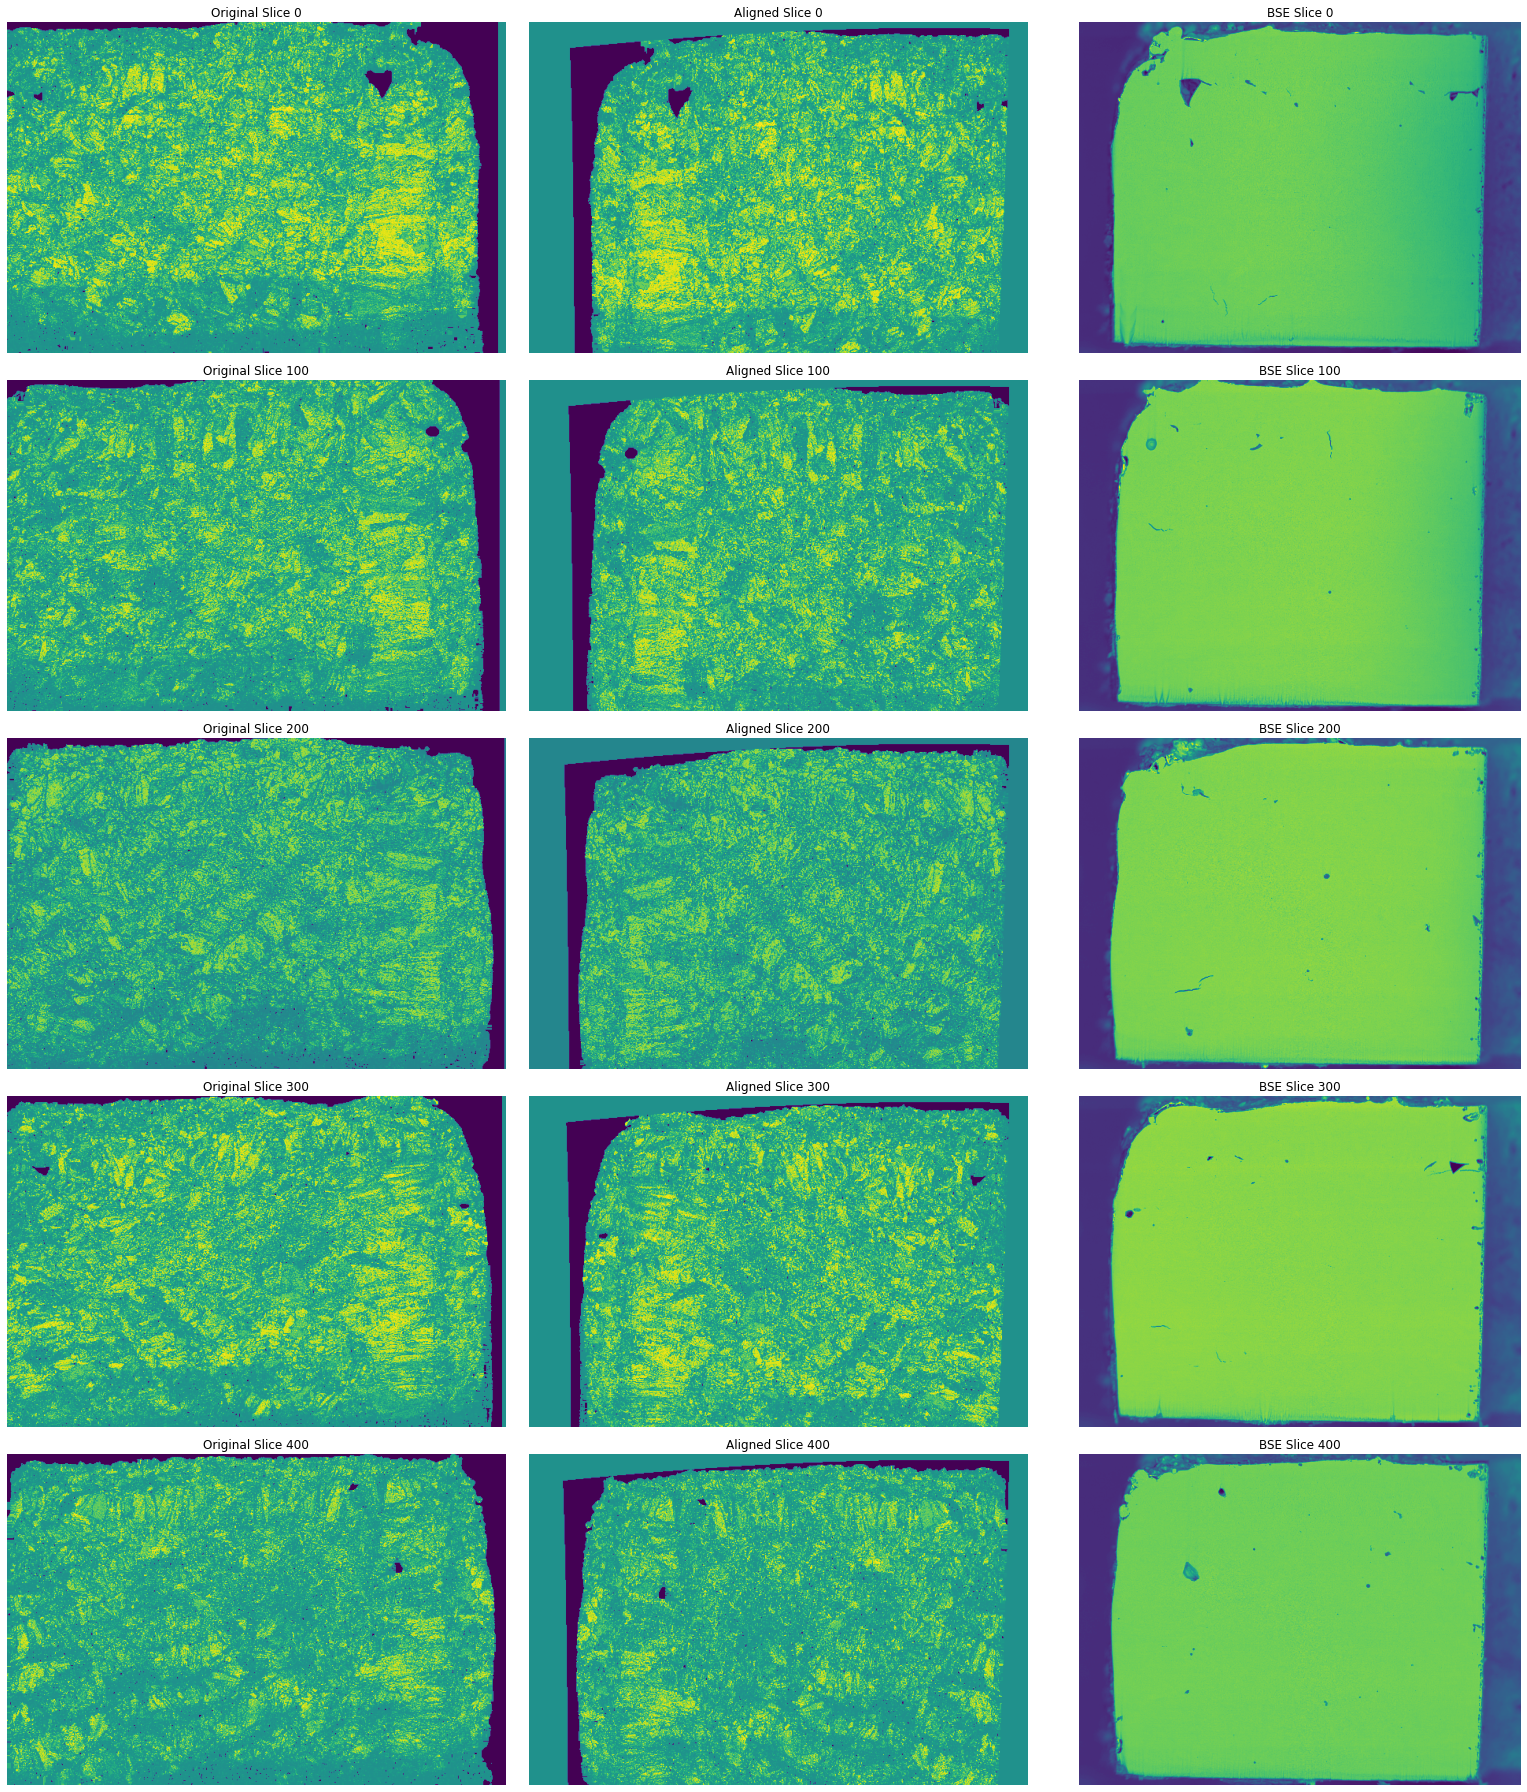

In [30]:
fig = plt.figure(1, figsize=(22, 25))
count = 1
for i in range(5):
    for j in range(3):
        if j == 0:
            im = dataset[i*100]
            title = "Original Slice {}".format(i*100)
        elif j == 1:
            im = aligned_dataset[i*100]
            title = "Aligned Slice {}".format(i*100)
        else:
            im = bse_imgs[i*100]
            title = "BSE Slice {}".format(i*100)
        ax = fig.add_subplot(5, 3, count)
        ax.imshow(im)
        ax.set_title(title)
        ax.axis("off")
        count += 1
plt.tight_layout()
plt.show()